In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(


q="name = 'Dataset_1.zip'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/Dataset_1.zip"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 4%.
Download 9%.
Download 14%.
Download 18%.
Download 23%.
Download 28%.
Download 33%.
Download 37%.
Download 42%.
Download 47%.
Download 52%.
Download 56%.
Download 61%.
Download 66%.
Download 70%.
Download 75%.
Download 80%.
Download 85%.
Download 89%.
Download 94%.
Download 99%.
Download 100%.


In [0]:
!unzip Dataset_1.zip

Archive:  Dataset_1.zip
   creating: Dataset_1/Benign/
  inflating: Dataset_1/Benign/img1.png  
  inflating: Dataset_1/Benign/img10.png  
  inflating: Dataset_1/Benign/img100.png  
  inflating: Dataset_1/Benign/img1000.png  
  inflating: Dataset_1/Benign/img1001.png  
  inflating: Dataset_1/Benign/img1002.png  
  inflating: Dataset_1/Benign/img1003.png  
  inflating: Dataset_1/Benign/img1004.png  
  inflating: Dataset_1/Benign/img1005.png  
  inflating: Dataset_1/Benign/img1006.png  
  inflating: Dataset_1/Benign/img1007.png  
  inflating: Dataset_1/Benign/img1008.png  
  inflating: Dataset_1/Benign/img1009.png  
  inflating: Dataset_1/Benign/img101.png  
  inflating: Dataset_1/Benign/img1010.png  
  inflating: Dataset_1/Benign/img1011.png  
  inflating: Dataset_1/Benign/img1012.png  
  inflating: Dataset_1/Benign/img1013.png  
  inflating: Dataset_1/Benign/img1014.png  
  inflating: Dataset_1/Benign/img1015.png  
  inflating: Dataset_1/Benign/img1016.png  
  inflating: Dataset_1/Benig

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import os

#os.chdir('Dataset')
import numpy as np
import pandas as pd
import cv2
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
#style.use('ggplot')
style.use('seaborn-darkgrid')

import keras.backend as K

from keras.models import Sequential,Model
import tensorflow as tf
print(tf.__version__)

from keras.layers import MaxPooling2D,Reshape,Cropping2D,Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D,BatchNormalization,UpSampling2D,Conv2DTranspose
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img



Using TensorFlow backend.


1.15.2


In [0]:
def histo_equalized(imgs):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    imgs_equalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_equalized[i,0] = cv2.equalizeHist(np.array(imgs[i,0], dtype = np.uint8))
    return imgs_equalized

In [0]:
def clahe_equalized(imgs):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    #create a CLAHE object (Arguments are optional).
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    imgs_equalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        imgs_equalized[i,0] = clahe.apply(np.array(imgs[i,0], dtype = np.uint8))
    return imgs_equalized


In [0]:
def dataset_normalized(imgs):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    imgs_normalized = np.empty(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs-imgs_mean)/imgs_std
    for i in range(imgs.shape[0]):
        imgs_normalized[i] = ((imgs_normalized[i] - np.min(imgs_normalized[i])) / (np.max(imgs_normalized[i])-np.min(imgs_normalized[i])))*255
    return imgs_normalized


def adjust_gamma(imgs, gamma=1.0):
    assert (len(imgs.shape)==4)  #4D arrays
    assert (imgs.shape[1]==1)  #check the channel is 1
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    new_imgs = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        new_imgs[i,0] = cv2.LUT(np.array(imgs[i,0], dtype = np.uint8), table)
    return new_imgs

In [0]:
def rgb2gray(rgb):
    assert (len(rgb.shape)==4)  #4D arrays
    assert (rgb.shape[1]==3)
    bn_imgs = rgb[:,0,:,:]*0.299 + rgb[:,1,:,:]*0.587 + rgb[:,2,:,:]*0.114
    bn_imgs = np.reshape(bn_imgs,(rgb.shape[0],1,rgb.shape[2],rgb.shape[3]))
    return bn_imgs


In [0]:
def my_PreProc(data):
    assert(len(data.shape)==4)
    assert (data.shape[1]==3)  #Use the original images
    #black-white conversion
    train_imgs = rgb2gray(data)
    #my preprocessing:
    train_imgs = dataset_normalized(train_imgs)
    train_imgs = clahe_equalized(train_imgs)
    train_imgs = adjust_gamma(train_imgs, 1.2)
    train_imgs = train_imgs/255.  #reduce to 0-1 range
    assert train_imgs.min() >= 0 and train_imgs.max() <= 1
    return train_imgs

In [0]:
DATA=[]
LABEL=[]

In [0]:
os.chdir('Dataset_1')
from PIL import Image
data1=os.listdir('Benign')
data2=os.listdir('InSitu')
data3=os.listdir('Invasive')
data4=os.listdir('Normal')

DATA=[]
LABEL=[]
newsize=(350,350)
'''
for i in range(0,len(data1)):
  im=Image.open('Benign/'+data1[i])
  res= im.resize(newsize)
  res=np.array(res)
  DATA.append(res)
  LABEL.append(0)
print("Done")
'''
for i in range(0,len(data2)):
  im=Image.open('InSitu/'+data2[i])
  res= im.resize(newsize)
  res=np.array(res)
  DATA.append(res)
  LABEL.append(0)
print("Done")
for i in range(0,len(data3)):
  im=Image.open('Invasive/'+data3[i])
  res= im.resize(newsize)
  res=np.array(res)
  DATA.append(res)
  LABEL.append(1)
print("Done")
'''
for i in range(0,len(data4)):
  im=Image.open('Normal/'+data4[i])
  res= im.resize(newsize)
  res=np.array(res)
  DATA.append(res)
  LABEL.append(1)
print("Done")
'''

Done
Done


'\nfor i in range(0,len(data4)):\n  im=Image.open(\'Normal/\'+data4[i])\n  res= im.resize(newsize)\n  res=np.array(res)\n  DATA.append(res)\n  LABEL.append(1)\nprint("Done")\n'

In [0]:
print (np.array(DATA).shape,np.array(LABEL).shape)

(2400, 350, 350, 3) (2400,)


In [0]:
DATA=np.array(DATA)
LABEL=np.array(LABEL)


In [0]:
DATA=np.rollaxis(DATA,3, 1) 
DATA=my_PreProc(DATA)
DATA=np.moveaxis(DATA,1, 3)


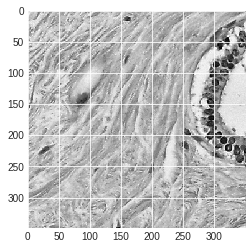

In [0]:
import matplotlib.pyplot as plt
plt.imshow(DATA[0, :, :, 0], cmap='gray')
plt.show()

In [0]:
from sklearn.model_selection import train_test_split
(trainX, testX, trainY, testY) = train_test_split(DATA,LABEL, test_size=0.2, random_state=50)#random state was 42 before

In [0]:
datagen = ImageDataGenerator(
    rotation_range=20,
    vertical_flip=True,
    horizontal_flip=True)
datagen.fit(trainX)

In [0]:
from sklearn.utils import class_weight
weights=class_weight.compute_class_weight('balanced',np.unique(trainY),trainY)
print(weights)

[1. 1.]


In [0]:
from keras.models import Sequential,Model

from keras.optimizers import Adagrad,RMSprop

from keras.layers import MaxPooling2D,Reshape,Activation,Cropping2D,Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D,BatchNormalization,UpSampling2D,Conv2DTranspose
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

'''
model=Sequential()
in_lay=Input((400,400,1))

model.add(Conv2D(32, kernel_size = (3,3),strides=(1,1), padding = 'same',input_shape=(350,350,1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = (3,3),strides=(1,1), padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size = (3,3),strides=(1,1), padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size = (3,3),strides=(1,1), padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size = (3,3),strides=(1,1), padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size = (3,3),strides=(1,1), padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size = (3,3),strides=(1,1), padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics=['accuracy'])
model.summary()
'''


in_lay=Input((350,350,1))


l1=Conv2D(32, kernel_size = (3,3),strides=(1,1), padding = 'same',activation = 'relu')(in_lay)
l1=MaxPooling2D(pool_size=(2, 2), strides=2)(l1)
l1=BatchNormalization()(l1)



l1=Conv2D(64, kernel_size = (3,3),strides=(1,1), padding = 'same',activation = 'relu')(l1)
l1=MaxPooling2D(pool_size=(2, 2), strides=2)(l1)
l1=BatchNormalization()(l1)

l1=Conv2D(128, kernel_size = (3,3),strides=(1,1), padding = 'same',activation = 'relu')(l1)
l1=MaxPooling2D(pool_size=(2, 2), strides=2)(l1)
l1=BatchNormalization()(l1)


l1=Conv2D(256, kernel_size = (3,3),strides=(1,1), padding = 'same',activation = 'relu')(l1)
l1=MaxPooling2D(pool_size=(2, 2), strides=2)(l1)
l1=BatchNormalization()(l1)

l1=Conv2D(256, kernel_size = (3,3),strides=(1,1), padding = 'same',activation = 'relu')(l1)
l1=MaxPooling2D(pool_size=(2, 2), strides=2)(l1)
l1=BatchNormalization()(l1)


l1=Conv2D(512, kernel_size = (3,3),strides=(1,1), padding = 'same',activation = 'relu')(l1)
l1=MaxPooling2D(pool_size=(2, 2), strides=2)(l1)
l1=BatchNormalization()(l1)

l1=Conv2D(512, kernel_size = (3,3),strides=(1,1), padding = 'same',activation = 'relu')(l1)
l1=MaxPooling2D(pool_size=(2, 2), strides=2)(l1)
l1=BatchNormalization()(l1)

l1=Flatten()(l1)#
#l1=Dense(units=2048,activation='relu')(l1)
l1=Dense(units=512,activation='relu')(l1)
Out=Dense(units=1,activation='sigmoid')(l1)




model=Model(inputs = [in_lay], outputs = [Out])
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics=['accuracy'])
model.summary()

















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 350, 350, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 350, 350, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 175, 175, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 175, 175, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 175, 175, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 87, 87, 64)        0         
_________________

In [0]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights_best.hdf5".format('cancer')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0000001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=150)
callbacks_list = [checkpoint, early, reduceLROnPlat,]
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [0]:
from google.colab import files
files.download('model.json')


In [0]:
#hist=model.fit(DATA,LABEL,batch_size=150,validation_data=(DATAt,LABELt),epochs=200,shuffle=True)
#hist=model.fit(trainX,trainY,batch_size=100,validation_data=(testX,testY),callbacks=callbacks_list,use_multiprocessing=True,epochs=100,shuffle=True)
hist=model.fit_generator(datagen.flow(trainX,trainY,batch_size=150),validation_data=(testX,testY),steps_per_epoch=len(trainX)/150,callbacks=callbacks_list,use_multiprocessing=True,epochs=100,shuffle=True)



Epoch 1/100
13/12 [==============================] - 20s 2s/step - loss: 1.7530 - acc: 0.5756 - val_loss: 3.4950 - val_acc: 0.5396

Epoch 00001: val_loss improved from inf to 3.49505, saving model to cancer_weights_best.hdf5
Epoch 2/100
13/12 [==============================] - 15s 1s/step - loss: 0.6999 - acc: 0.6879 - val_loss: 4.1078 - val_acc: 0.5458

Epoch 00002: val_loss did not improve from 3.49505
Epoch 3/100
13/12 [==============================] - 17s 1s/step - loss: 0.5788 - acc: 0.7445 - val_loss: 1.4874 - val_acc: 0.5479

Epoch 00003: val_loss improved from 3.49505 to 1.48738, saving model to cancer_weights_best.hdf5
Epoch 4/100
13/12 [==============================] - 16s 1s/step - loss: 0.6108 - acc: 0.7383 - val_loss: 2.5978 - val_acc: 0.5979

Epoch 00004: val_loss did not improve from 1.48738
Epoch 5/100
13/12 [==============================] - 16s 1s/step - loss: 0.6721 - acc: 0.7350 - val_loss: 1.4912 - val_acc: 0.6146

Epoch 00005: val_loss did not improve from 1.4

In [0]:
from keras.models import model_from_json
json_file = open('model.json','r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
#load woeights into new model
loaded_model.load_weights("cancer_weights_best.hdf5")
print("Loaded Model from disk")
loaded_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',metrics=['accuracy'])
graph = tf.get_default_graph()

Loaded Model from disk


In [0]:
def discrete(pred):
  res=[]
  for i in pred:
    if(i>0.5):
      res.append(1)
    else:
      res.append(0)
  return res

Insitu Vs Invasive
Accuracy :  0.8833333333333333
Sensitivity :  0.8583333333333333
Specificity :  0.9083333333333333


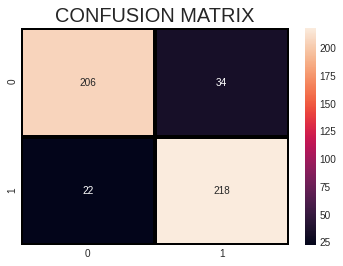

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Y_pred = loaded_model.predict(testX)
prediction=discrete(Y_pred)
prediction=np.array(prediction)
print('Insitu Vs Invasive')
conf=confusion_matrix(testY, prediction)
sns.heatmap(conf,annot=True,fmt = "d",linecolor="k",linewidths=3)
plt.title("CONFUSION MATRIX",fontsize=20)
total1=sum(sum(conf))
accuracy1=(conf[0,0]+conf[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = conf[0,0]/(conf[0,0]+conf[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = conf[1,1]/(conf[1,0]+conf[1,1])
print('Specificity : ', specificity1)


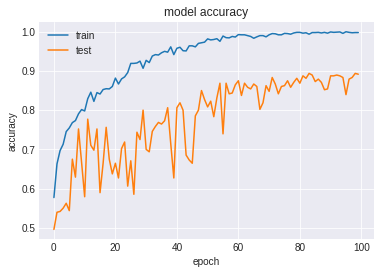

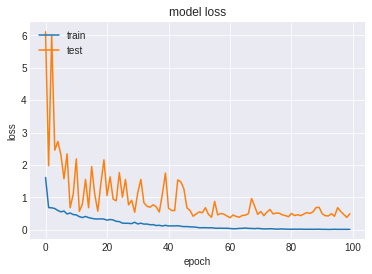

In [0]:
import matplotlib.pyplot as plt
import numpy
print(hist)
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
from google.colab import files
files.download('cancer_weights_best.hdf5')


# New Section